# Random Forest, XGBoost e LSTM na Predição de Sepse a partir de dados de Unidade de Terapia Intensiva
Script utilizado no desenvolvimento do Trabalho de Conclusao de Curso do MBA em Data Science e Analytics - USP ESALQ (2024)

### **Autor:** Danillo Rodrigues da Silva.
---

## **Descrição do  conjunto de dados utilizado:**

Os dados utilizados neste estudo foram disponibilizados pela competição PhysioNet Challenge 2019, conforme descrito em: https://physionet.org/content/challenge-2019/. O conjunto de dados é composto por registros de 25.303 pacientes hospitalizados em UTIs de três hospitais: Beth Israel Deaconess Medical Center (Boston, Estados Unidos) e Emory University Hospital (Atlanta, Estados Unidos). Estes dados são públicos e incluem 40 variáveis, entre elas, dados demográficos, sinais vitais e exames laboratoriais.

---

## **Estrutura do Notebook:**

1. **Importação das Bibliotecas, Carregamento e Visualização dos Dados**: Os dados são carregados e visualizados para entender a estrutura e o conteúdo.
2. **Pré-processamento e Limpeza dos Dados**: Nesta etapa, os dados são limpos e preparados para a análise, incluindo tratamento de valores ausentes e codificação de variáveis categóricas.
4. **Modelagem**: Construção e avaliação de modelos de aprendizado de máquina para a previsão de sepse.
5. **Análise de Feature Importance e Conclusao**: Resumo dos principais achados e considerações finais.

---

## **Referências:**

- Reyna, M. A., Josef, C., Jeter, R., Shashikumar, S. P., Westover, M. B., Nemati, S., Sharma, A., & Clifford, G. D. (2019). Early Prediction of Sepsis from Clinical Data: The PhysioNet/Computing in Cardiology Challenge 2019. *Critical Care Medicine*. https://physionet.org/content/challenge-2019/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('/content/raw_dataset.csv')

# Display the first few rows of the dataframe for EDA
print(data.head())

   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54     0.0    NaN    NaN        -0.02     1.0   
1         NaN        NaN  68.54     0.0    NaN    NaN        -0.02     2.0   
2         NaN        NaN  68.54     0.0    NaN    NaN        -0.02     3.0   
3         NaN        NaN  68.54     0.0    NaN    NaN        -0.02     4.0   
4         NaN      330.0  68.54     0.0    NaN    NaN        -0.02     5.0   

   SepsisLabel  Patient_ID  
0          0.0     17072.0 

<ipython-input-3-2bffec29f0a9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=missing_data_sorted.index, x=missing_data_sorted.values, palette='viridis')


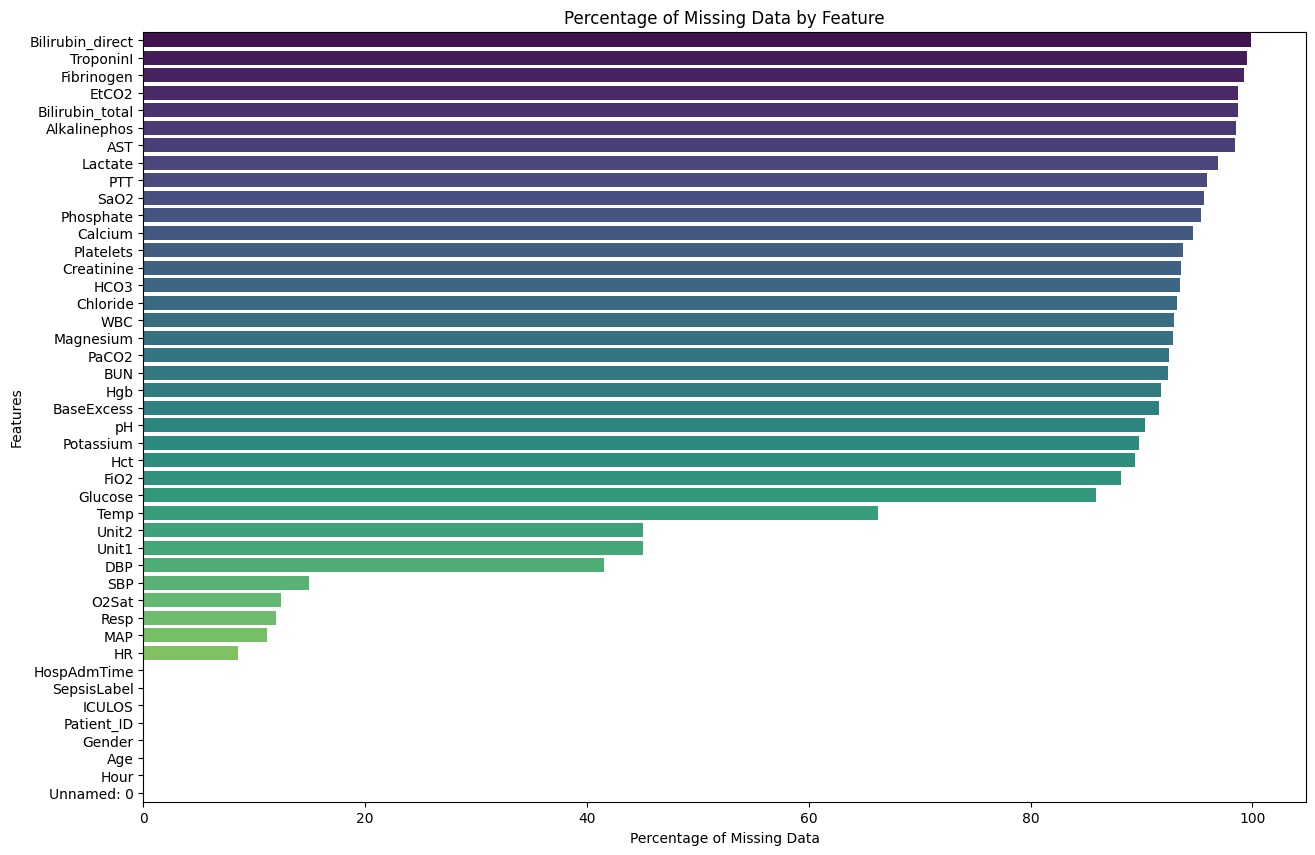

In [3]:
# Calculate the percentage of missing data for each feature
missing_data = data.isnull().mean() * 100

# Sort the features by percentage of missing data descending
missing_data_sorted = missing_data.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(15, 10))  # Adjust the size as needed
sns.barplot(y=missing_data_sorted.index, x=missing_data_sorted.values, palette='viridis')
plt.title('Percentage of Missing Data by Feature')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Features')

# Show the plot
plt.show()


<Figure size 1000x1500 with 0 Axes>

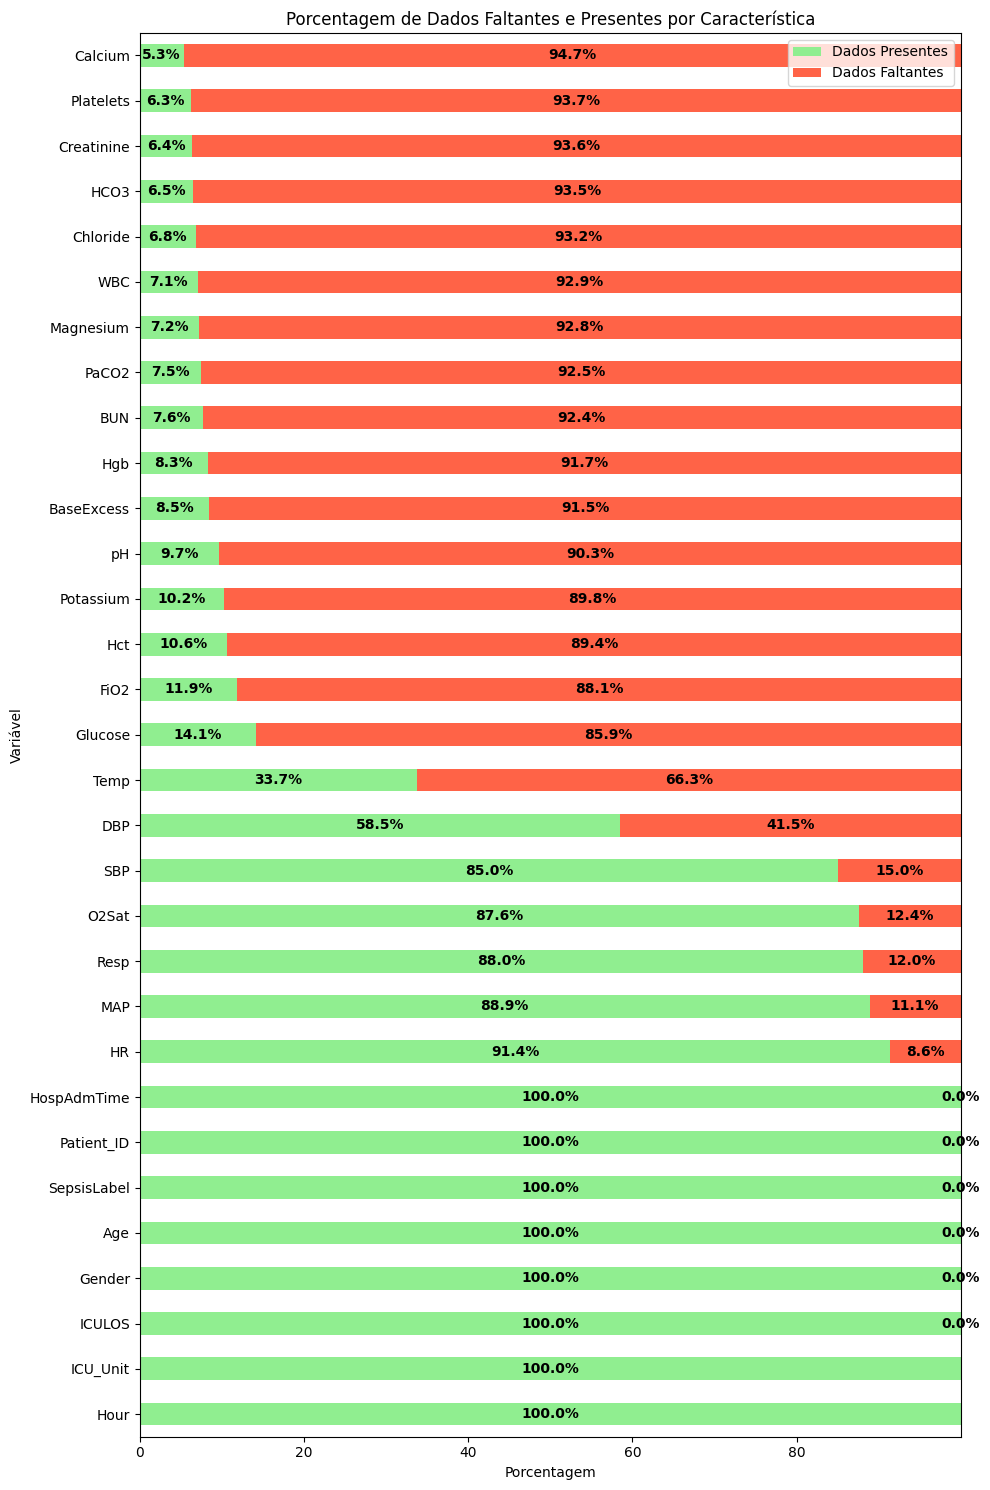

In [6]:
# Calcular a porcentagem de dados faltantes para cada feature
missing_data = data.isnull().mean() * 100
present_data = 100 - missing_data

# Criar um DataFrame para o gráfico
plot_data = pd.DataFrame({'Dados Presentes': present_data, 'Dados Faltantes': missing_data})

# Ordenar as características pela porcentagem de dados faltantes em ordem crescente
plot_data_sorted = plot_data.sort_values(by='Dados Faltantes', ascending=True)

# Plotagem
plt.figure(figsize=(10, 15))  # Ajustar o tamanho conforme necessário
plot_data_sorted.plot(kind='barh', stacked=True, color=['lightgreen', 'tomato'], figsize=(10, 15))

# Adicionar texto de porcentagem em preto
for n, (pres, miss) in enumerate(zip(plot_data_sorted['Dados Presentes'], plot_data_sorted['Dados Faltantes'])):
    if pres > 0:
        plt.text(pres / 2, n, f'{pres:.1f}%', ha='center', va='center', fontweight='bold', color='black')
    if miss > 0:
        plt.text(pres + miss / 2, n, f'{miss:.1f}%', ha='center', va='center', fontweight='bold', color='black')

plt.title('Porcentagem de Dados Faltantes e Presentes por Característica')
plt.xlabel('Porcentagem')
plt.ylabel('Variável')

# Exibir o gráfico
plt.tight_layout()  # Ajustar o preenchimento
plt.show()

In [5]:
# Load the dataset
data = pd.read_csv('/content/raw_dataset.csv', index_col=False)

# Remover variáveis com mais de 95% de dados faltantes
missing_data = data.isnull().mean() * 100
data = data.loc[:, missing_data <= 95]

# Merge Unit1 and Unit2 into a single 'ICU_Unit' column
data['ICU_Unit'] = -1  # Initialize with a default value
data.loc[data['Unit1'] == 1, 'ICU_Unit'] = 0  # Assign 0 to Unit1 (MICU)
data.loc[data['Unit2'] == 1, 'ICU_Unit'] = 1  # Assign 1 to Unit2 (SICU)

# Drop the original Unit1 and Unit2 columns
data.drop(['Unnamed: 0','Unit1', 'Unit2'], axis=1, inplace=True)

# Move 'SepsisLabel' to the end
sepsis_label = data.pop('SepsisLabel')
data['SepsisLabel'] = sepsis_label

# Move 'SepsisLabel' to the end
patient_id = data.pop('Patient_ID')
data['Patient_ID'] = patient_id

# Perform forward fill within each group of 'Patient_ID'
data_filled = data.groupby('Patient_ID').ffill()
data_filled['Patient_ID'] = patient_id

# After forward filling, if there's still missing data, fill it with 0
data_filled.fillna(0, inplace=True)

# Save the filled data if needed
data_filled.to_csv('/content/cleaned_dataset.csv', index=False)
data_filled.head()

<ipython-input-5-e2df105b59a0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ICU_Unit'] = -1  # Initialize with a default value


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,ICU_Unit,SepsisLabel,Patient_ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,68.54,0.0,-0.02,1.0,-1.0,0.0,17072.0
1,1.0,65.0,100.0,0.0,0.0,72.0,0.0,16.5,0.0,0.0,...,0.0,0.0,0.0,68.54,0.0,-0.02,2.0,-1.0,0.0,17072.0
2,2.0,78.0,100.0,0.0,0.0,42.5,0.0,16.5,0.0,0.0,...,0.0,0.0,0.0,68.54,0.0,-0.02,3.0,-1.0,0.0,17072.0
3,3.0,73.0,100.0,0.0,0.0,42.5,0.0,17.0,0.0,0.0,...,0.0,0.0,0.0,68.54,0.0,-0.02,4.0,-1.0,0.0,17072.0
4,4.0,70.0,100.0,0.0,129.0,74.0,69.0,14.0,0.0,26.0,...,9.5,11.3,330.0,68.54,0.0,-0.02,5.0,-1.0,0.0,17072.0


<ipython-input-7-c1f4b23e9bee>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=class_counts.index, y=class_counts.values, palette='coolwarm')
<ipython-input-7-c1f4b23e9bee>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['Não-Séptico', 'Séptico'])
<ipython-input-7-c1f4b23e9bee>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=patient_counts.index, y=patient_counts.values, palette='coolwarm')
<ipython-input-7-c1f4b23e9bee>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['Não-Séptico', 'Séptico'])


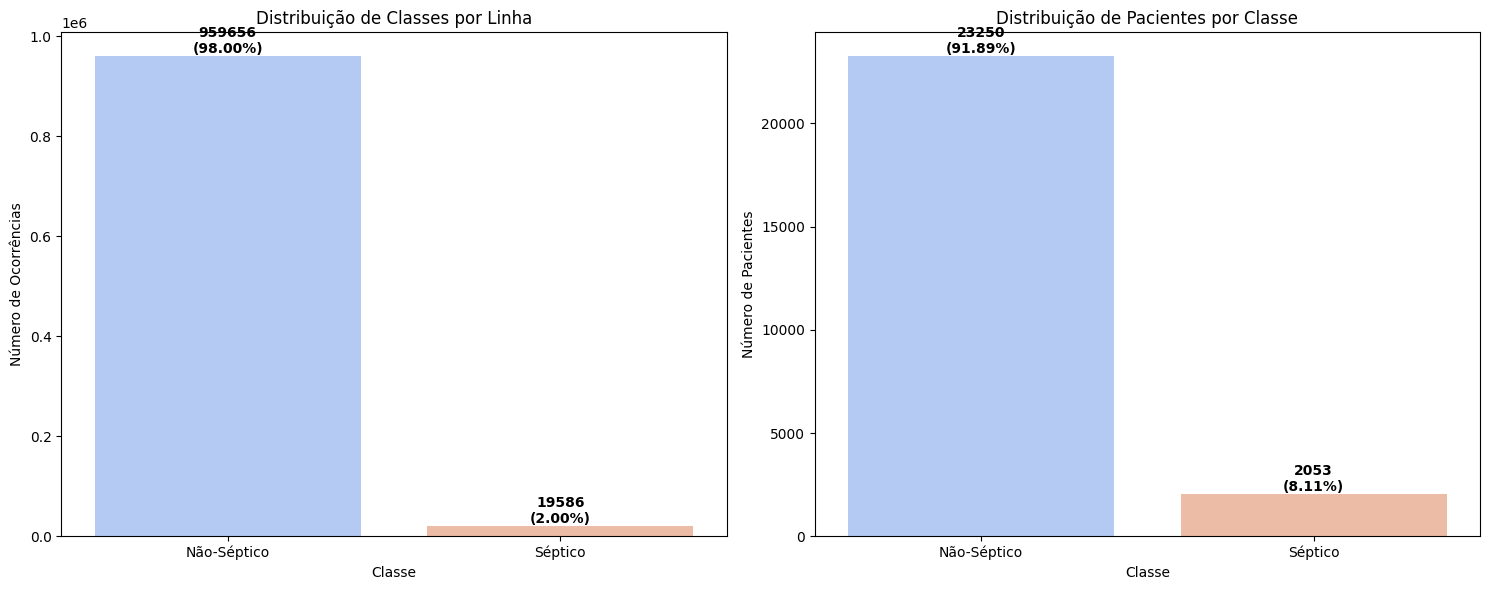

In [7]:
# Load the cleaned dataset
data_cleaned = pd.read_csv('/content/cleaned_dataset.csv', index_col=False)

# Count the number of instances in each class
class_counts = data_cleaned['SepsisLabel'].value_counts()

# Calculate the percentage of each class
total_counts = class_counts.sum()
class_percentage = (class_counts / total_counts) * 100

# Count the number of unique patients in each class
patient_counts = data_cleaned.groupby('Patient_ID')['SepsisLabel'].max().value_counts()
patient_total_counts = patient_counts.sum()
patient_percentage = (patient_counts / patient_total_counts) * 100

# Set up the figure for multiple plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the row count ratio
sns.barplot(ax=axes[0], x=class_counts.index, y=class_counts.values, palette='coolwarm')
axes[0].set_title('Distribuição de Classes por Linha')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Número de Ocorrências')
axes[0].set_xticklabels(['Não-Séptico', 'Séptico'])
for bar, count, percentage in zip(axes[0].patches, class_counts.values, class_percentage.values):
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}\n({percentage:.2f}%)',
                 ha='center', va='bottom', color='black', fontweight='bold')

# Plot for the patient ratio
sns.barplot(ax=axes[1], x=patient_counts.index, y=patient_counts.values, palette='coolwarm')
axes[1].set_title('Distribuição de Pacientes por Classe')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Número de Pacientes')
axes[1].set_xticklabels(['Não-Séptico', 'Séptico'])
for bar, count, percentage in zip(axes[1].patches, patient_counts.values, patient_percentage.values):
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}\n({percentage:.2f}%)',
                 ha='center', va='bottom', color='black', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

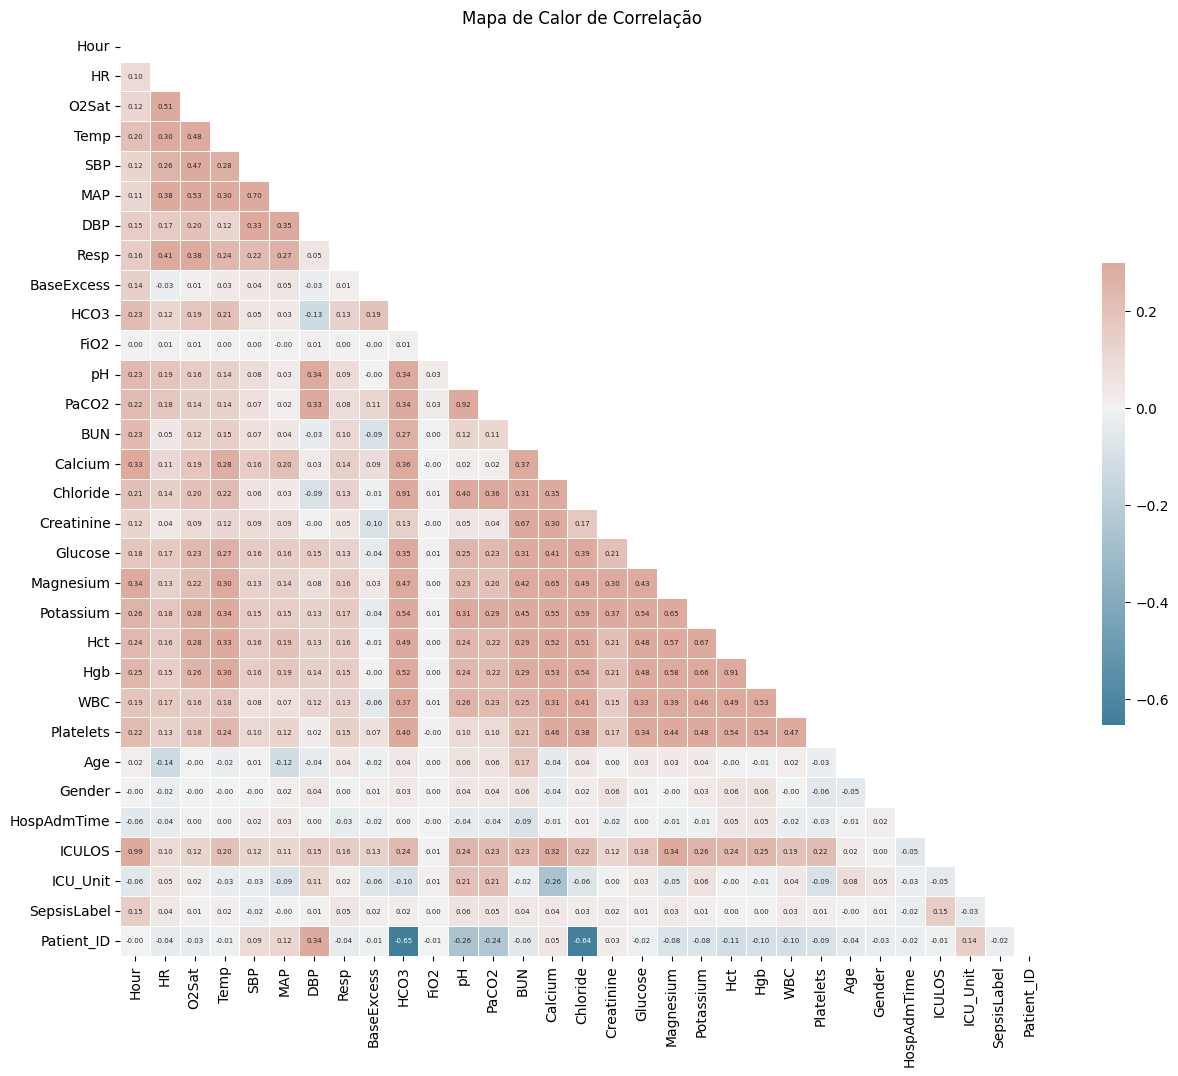

In [8]:
data_cleaned = pd.read_csv('/content/cleaned_dataset.csv', index_col=False)

# Compute the correlation matrix
corr = data_cleaned.corr()

# Generate a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size": 5})

plt.title('Mapa de Calor de Correlação')
plt.show()

In [9]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming data_filled is already loaded and has 'Patient_ID', 'Hour', and other columns
# Create a copy of the dataframe to avoid SettingWithCopyWarning
data_with_lags = pd.read_csv('/content/cleaned_dataset.csv', index_col=False)

# Define the variables for which we want to create lagged differences
# We'll exclude the first column and the columns from 36 to the end, which are not part of the continuous variables
non_lagged_columns = list(data_with_lags.columns[:1]) + list(data_with_lags.columns[35:])
variables_to_lag = [col for col in data_with_lags.columns if col not in non_lagged_columns]

# Add the measures from 6 hours earlier for each variable
for var in variables_to_lag:
    # Create the lagged variable name
    lagged_var_name = f'previous_{var}'
    # Group by 'Patient_ID' and shift by 6 hours
    data_with_lags[lagged_var_name] = data_with_lags.groupby('Patient_ID')[var].shift(6)

# Fill NaN values in lagged columns with 0 (or any other method you prefer)
data_with_lags.fillna(0, inplace=True)

# Now for log transformation + z-score, exclude the non-lagged columns and the 'Patient_ID'
log_zscore_columns = variables_to_lag + [f'previous_{var}' for var in variables_to_lag]

# Apply log transformation and z-score standardization only to the columns that are continuous variables
data_with_lags[log_zscore_columns] = data_with_lags[log_zscore_columns].apply(lambda x: np.log(x.clip(lower=1e-9)))
scaler = StandardScaler()
data_with_lags[log_zscore_columns] = scaler.fit_transform(data_with_lags[log_zscore_columns])

# Move 'SepsisLabel' to the end
sepsis_label = data_with_lags.pop('SepsisLabel')
data_with_lags['SepsisLabel'] = sepsis_label

# Move 'SepsisLabel' to the end
patient_id = data_with_lags.pop('Patient_ID')
data_with_lags['Patient_ID'] = patient_id

# Output the transformed dataframe
data_filled.to_csv('/content/normalized_dataset.csv', index=False)
data_with_lags.head()


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,previous_Platelets,previous_Age,previous_Gender,previous_HospAdmTime,previous_ICULOS,previous_ICU_Unit,previous_SepsisLabel,previous_Patient_ID,SepsisLabel,Patient_ID
0,0.0,-7.077055,-6.743535,-3.556489,-4.671713,-6.638915,-1.493316,-6.267975,-0.458245,-1.445524,...,-1.376961,-2.333418,-0.962903,-0.084637,-2.321792,-0.54578,-0.086629,-2.318785,-0.142861,0.21951
1,1.0,0.070726,0.156248,-3.556489,-4.671713,0.125420,-1.493316,0.134597,-0.458245,-1.445524,...,-1.376961,-2.333418,-0.962903,-0.084637,-2.321792,-0.54578,-0.086629,-2.318785,-0.142861,0.21951
2,2.0,0.123068,0.156248,-3.556489,-4.671713,-0.017217,-1.493316,0.134597,-0.458245,-1.445524,...,-1.376961,-2.333418,-0.962903,-0.084637,-2.321792,-0.54578,-0.086629,-2.318785,-0.142861,0.21951
3,3.0,0.104049,0.156248,-3.556489,-4.671713,-0.017217,-1.493316,0.142722,-0.458245,-1.445524,...,-1.376961,-2.333418,-0.962903,-0.084637,-2.321792,-0.54578,-0.086629,-2.318785,-0.142861,0.21951
4,4.0,0.092002,0.156248,-3.556489,0.227663,0.132833,0.680477,0.089884,-0.458245,0.698855,...,-1.376961,-2.333418,-0.962903,-0.084637,-2.321792,-0.54578,-0.086629,-2.318785,-0.142861,0.21951


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/normalized_dataset.csv')

# Generate a list of unique patient IDs
patient_ids = data['Patient_ID'].unique()

# Split patient IDs into training+validation and test sets
train_val_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Split training+validation IDs into training and validation sets
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the datasets
train = data[data['Patient_ID'].isin(train_ids)]
validation = data[data['Patient_ID'].isin(val_ids)]
test = data[data['Patient_ID'].isin(test_ids)]

# Shuffle the training set to ensure randomness
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Output the transformed dataframe
train.to_csv('/content/train_dataset.csv', index=False)
validation.to_csv('/content/validation_dataset.csv', index=False)
test.to_csv('/content/test_dataset.csv', index=False)

# Display the first few rows of the training set
train.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,ICU_Unit,SepsisLabel,Patient_ID
0,13.0,43.0,95.0,36.60,135.0,99.50,85.5,16.5,0.0,0.0,...,0.0,0.0,0.0,57.00,0.0,-63.70,14.0,-1.0,0.0,118733.0
1,5.0,102.0,98.5,37.33,145.0,92.00,0.0,18.0,0.0,34.0,...,10.5,11.8,197.0,65.33,1.0,-0.02,6.0,0.0,0.0,11843.0
2,6.0,79.0,100.0,37.80,108.0,83.00,66.0,22.0,-1.0,27.0,...,11.5,9.4,81.0,67.11,1.0,-16.58,9.0,1.0,0.0,15832.0
3,21.0,114.0,95.0,36.89,91.0,61.67,0.0,10.0,0.0,18.0,...,9.2,17.2,315.0,80.30,0.0,-190.03,22.0,0.0,0.0,542.0
4,23.0,96.0,97.0,37.28,120.0,86.00,66.0,16.0,7.0,33.0,...,9.2,14.6,452.0,49.49,0.0,-86.83,24.0,-1.0,0.0,19950.0


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# Load the balanced training set
balanced_train = pd.read_csv('/content/balanced_train_dataset.csv')

# Define a function to create LSTM sequences for each patient
def create_sequences(data, patient_ids, n_steps, features, label):
    X, y = [], []
    for pid in patient_ids:
        patient_data = data[data['Patient_ID'] == pid]
        for i in range(len(patient_data) - n_steps):
            X.append(patient_data[features].iloc[i:i + n_steps].values)
            y.append(patient_data[label].iloc[i + n_steps])
    return np.array(X), np.array(y)

# Define LSTM architecture
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Determine the features and label for training
features = balanced_train.drop(['Patient_ID', 'Hour', 'SepsisLabel'], axis=1).columns.tolist()
label = 'SepsisLabel'

# Set the number of time steps for sequences
n_steps = 6  # Number of time steps (e.g., 5 hours of data)

# Generate a list of unique patient IDs
patient_ids = balanced_train['Patient_ID'].unique()

# Prepare KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics storage
metrics_storage = {
    'accuracy': [],
    'auc': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Perform cross-validation
for train_index, test_index in kf.split(patient_ids):
    # Split patient IDs for this fold
    train_ids, test_ids = patient_ids[train_index], patient_ids[test_index]

    # Create sequences
    X_train, y_train = create_sequences(balanced_train, train_ids, n_steps, features, label)
    X_test, y_test = create_sequences(balanced_train, test_ids, n_steps, features, label)

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Initialize and fit the LSTM model
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    accuracy = (y_pred == y_test).mean()
    metrics_storage['accuracy'].append(accuracy)
    auc = roc_auc_score(y_test, y_pred_prob)
    metrics_storage['auc'].append(auc)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    metrics_storage['precision'].append(prec)
    metrics_storage['recall'].append(recall)
    metrics_storage['f1'].append(f1)

# Calculate and print the mean and standard deviation of the metrics
for metric, values in metrics_storage.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}, Standard Deviation: {std_val:.4f}')


620/620 [==============================] - 1s 2ms/step
Accuracy Mean: 0.9066, Standard Deviation: 0.0035
Auc Mean: 0.6392, Standard Deviation: 0.0083
Precision Mean: 0.8731, Standard Deviation: 0.0045
Recall Mean: 0.9066, Standard Deviation: 0.0035
F1 Mean: 0.8820, Standard Deviation: 0.0046


In [11]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import numpy as np
import pandas as pd

# Load the balanced training set
balanced_train = pd.read_csv('/content/train_dataset.csv')  # Path to your balanced training dataset CSV file

# Prepare the features and labels
X = balanced_train.drop(['Patient_ID', 'Hour', 'SepsisLabel'], axis=1)
y = balanced_train['SepsisLabel']

# Initialize the models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Prepare manual KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metric summaries for RF and XGB
rf_precision_list, rf_recall_list, rf_fscore_list, rf_auc_list = [], [], [], []
xgb_precision_list, xgb_recall_list, xgb_fscore_list, xgb_auc_list = [], [], [], []

# Lists to store feature importances
rf_feature_importances = []
xgb_feature_importances = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}")

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Random Forest
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC
    rf_auc = roc_auc_score(y_test, rf_probs)  # Calculate AUC-ROC
    rf_precision, rf_recall, rf_fbeta, _ = precision_recall_fscore_support(y_test, rf_pred, average='weighted')

    # Append metrics to RF lists
    rf_precision_list.append(rf_precision)
    rf_recall_list.append(rf_recall)
    rf_fscore_list.append(rf_fbeta)
    rf_auc_list.append(rf_auc)

    print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))
    print(f"Random Forest AUC-ROC: {rf_auc}")

    # Store RF feature importances
    rf_feature_importances.append(rf_model.feature_importances_)

    # XGBoost
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC
    xgb_auc = roc_auc_score(y_test, xgb_probs)  # Calculate AUC-ROC
    xgb_precision, xgb_recall, xgb_fbeta, _ = precision_recall_fscore_support(y_test, xgb_pred, average='weighted')

    # Append metrics to XGB lists
    xgb_precision_list.append(xgb_precision)
    xgb_recall_list.append(xgb_recall)
    xgb_fscore_list.append(xgb_fbeta)
    xgb_auc_list.append(xgb_auc)

    print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))
    print(f"XGBoost AUC-ROC: {xgb_auc}")

    # Store XGB feature importances
    xgb_feature_importances.append(xgb_model.feature_importances_)

# After completing all folds, calculate the mean of the summaries for each model

# RF metrics
rf_precision_mean = np.mean(rf_precision_list)
rf_recall_mean = np.mean(rf_recall_list)
rf_fscore_mean = np.mean(rf_fscore_list)
rf_auc_mean = np.mean(rf_auc_list)

# XGB metrics
xgb_precision_mean = np.mean(xgb_precision_list)
xgb_recall_mean = np.mean(xgb_recall_list)
xgb_fscore_mean = np.mean(xgb_fscore_list)
xgb_auc_mean = np.mean(xgb_auc_list)

# Create summary tables
rf_summary_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'RF Weighted Average': [rf_precision_mean, rf_recall_mean, rf_fscore_mean, rf_auc_mean]
})

xgb_summary_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'XGB Weighted Average': [xgb_precision_mean, xgb_recall_mean, xgb_fscore_mean, xgb_auc_mean]
})

# Display the summary tables
print("Random Forest Summary:\n", rf_summary_table)
print("\nXGBoost Summary:\n", xgb_summary_table)

# Feature Importances
rf_feature_importance_mean = np.mean(rf_feature_importances, axis=0)
xgb_feature_importance_mean = np.mean(xgb_feature_importances, axis=0)

# Store the feature importances
rf_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importance_mean})
xgb_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importance_mean})

# Print or save feature importance dataframes
print("Random Forest Feature Importances:\n", rf_feature_importance_df)
print("XGBoost Feature Importances:\n", xgb_feature_importance_df)


Fold 1
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115384
         1.0       0.94      0.67      0.78      2259

    accuracy                           0.99    117643
   macro avg       0.97      0.83      0.89    117643
weighted avg       0.99      0.99      0.99    117643

Random Forest AUC-ROC: 0.988605800821612
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    115384
         1.0       0.90      0.32      0.47      2259

    accuracy                           0.99    117643
   macro avg       0.94      0.66      0.73    117643
weighted avg       0.99      0.99      0.98    117643

XGBoost AUC-ROC: 0.9698906059799413
Fold 2
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115366
         1.0       0.95      0.66     

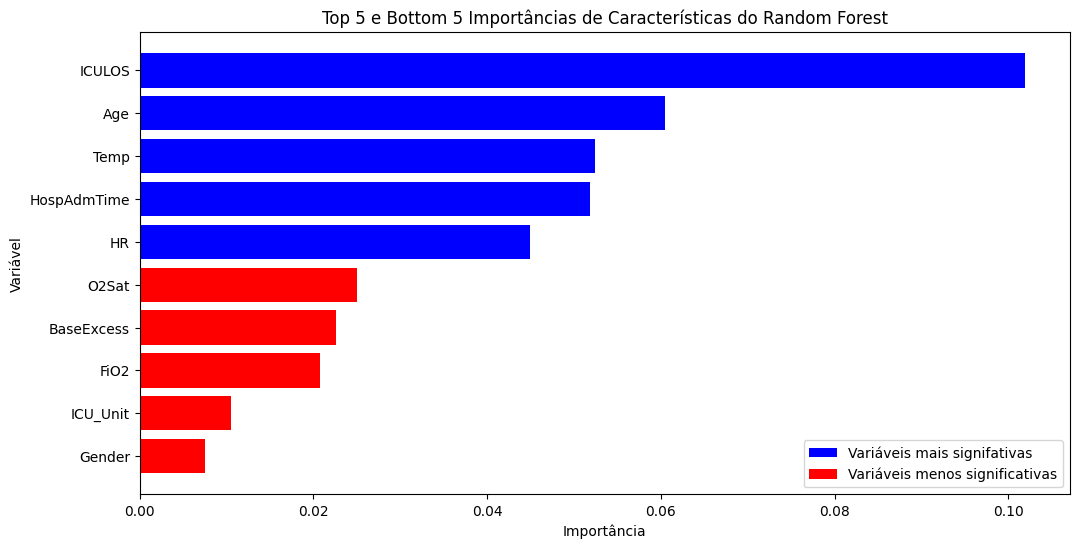

In [14]:
import matplotlib.pyplot as plt

# Ordenando as importâncias das características do Random Forest
rf_feature_importance_df_sorted = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Obtendo as top 5 e bottom 5 características
top_features_rf = rf_feature_importance_df_sorted['Feature'][:5]
top_importances_rf = rf_feature_importance_df_sorted['Importance'][:5]

bottom_features_rf = rf_feature_importance_df_sorted['Feature'][-5:]
bottom_importances_rf = rf_feature_importance_df_sorted['Importance'][-5:]

# Plotando as importâncias das características do Random Forest
plt.figure(figsize=(12, 6))

# Plotando as top 5 características em azul
plt.barh(top_features_rf, top_importances_rf, color='blue', label='Variáveis mais signifativas')

# Plotando as bottom 5 características em vermelho
plt.barh(bottom_features_rf, bottom_importances_rf, color='red', label='Variáveis menos significativas')

plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Top 5 e Bottom 5 Importâncias de Características do Random Forest')
plt.gca().invert_yaxis()  # Invertendo o eixo y para mostrar as características mais importantes no topo
plt.legend()
plt.show()


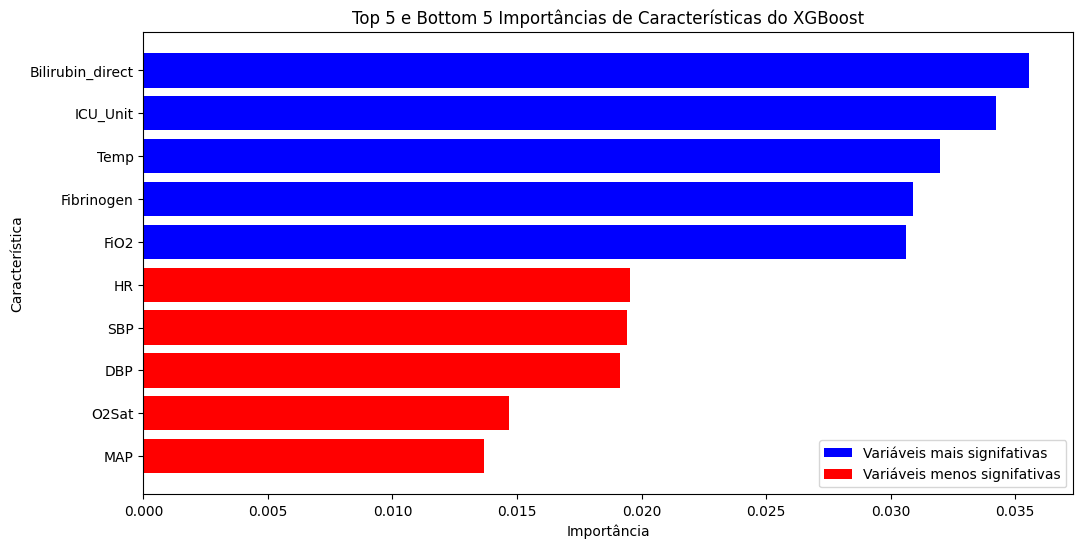

In [ ]:
# Ordenando as importâncias das características do XGBoost
xgb_feature_importance_df_sorted = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Obtendo as top 5 e bottom 5 características
top_features_xgb = xgb_feature_importance_df_sorted['Feature'][:5]
top_importances_xgb = xgb_feature_importance_df_sorted['Importance'][:5]

bottom_features_xgb = xgb_feature_importance_df_sorted['Feature'][-5:]
bottom_importances_xgb = xgb_feature_importance_df_sorted['Importance'][-5:]

# Plotando as importâncias das características do XGBoost
plt.figure(figsize=(12, 6))

# Plotando as top 5 características em azul
plt.barh(top_features_xgb, top_importances_xgb, color='blue', label='Variáveis mais signifativas')

# Plotando as bottom 5 características em vermelho
plt.barh(bottom_features_xgb, bottom_importances_xgb, color='red', label='Variáveis menos signifativas')

plt.xlabel('Importância')
plt.ylabel('Característica')
plt.title('Top 5 e Bottom 5 Importâncias de Características do XGBoost')
plt.gca().invert_yaxis()  # Invertendo o eixo y para mostrar as características mais importantes no topo
plt.legend()
plt.show()

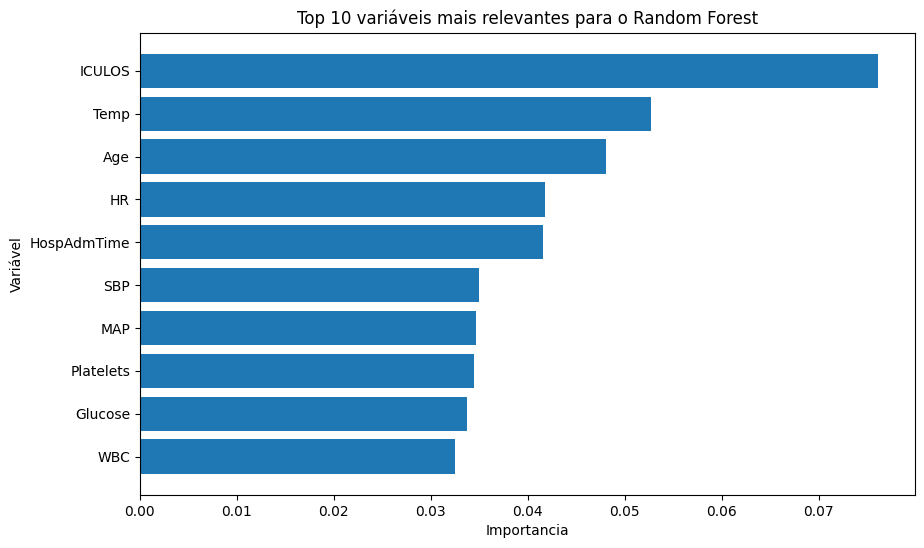

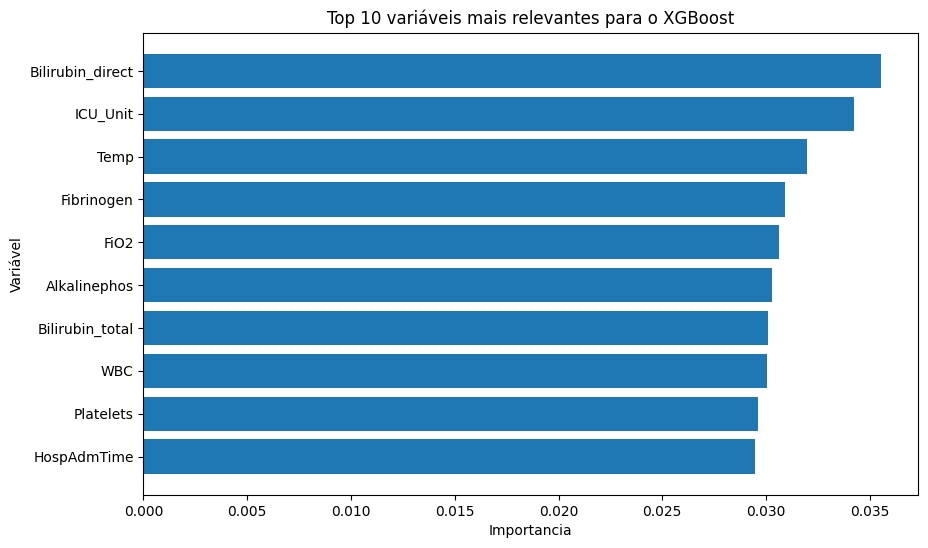

In [ ]:
import matplotlib.pyplot as plt

# Sorting Random Forest feature importances
rf_feature_importance_df_sorted = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting Random Forest feature importances
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_df_sorted['Feature'][:10], rf_feature_importance_df_sorted['Importance'][:10])
plt.xlabel('Importancia')
plt.ylabel('Variável')
plt.title('Top 10 variáveis mais relevantes para o Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()

# Sorting XGBoost feature importances
xgb_feature_importance_df_sorted = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting XGBoost feature importances
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df_sorted['Feature'][:10], xgb_feature_importance_df_sorted['Importance'][:10])
plt.xlabel('Importancia')
plt.ylabel('Variável')
plt.title('Top 10 variáveis mais relevantes para o XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()


620/620 [==============================] - 2s 2ms/step
Accuracy Mean: 0.9074, Standard Deviation: 0.0031
Auc Mean: 0.6372, Standard Deviation: 0.0122
Precision Mean: 0.8729, Standard Deviation: 0.0026
Recall Mean: 0.9074, Standard Deviation: 0.0031
F1 Mean: 0.8813, Standard Deviation: 0.0038


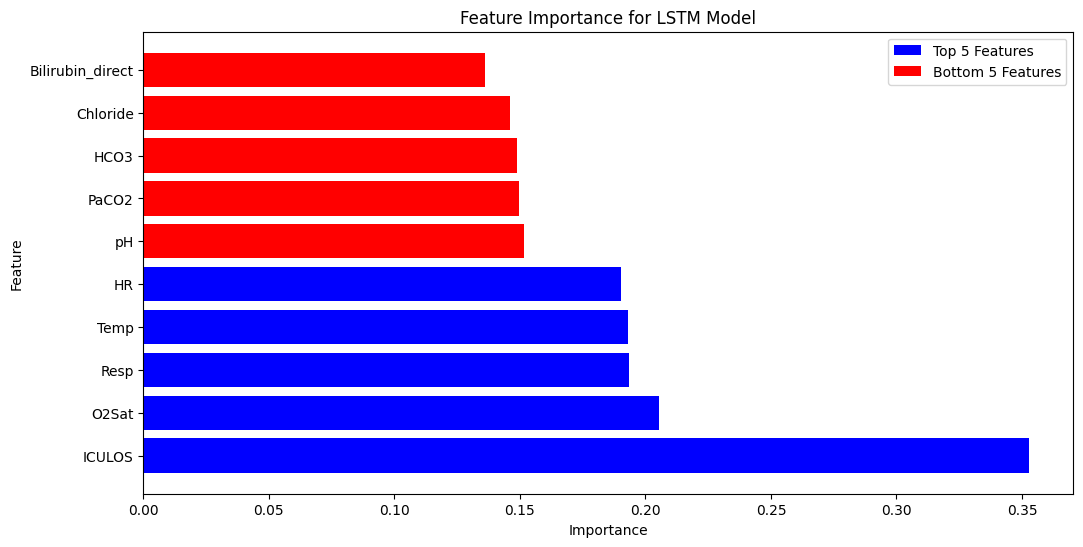

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the balanced training set
balanced_train = pd.read_csv('/content/balanced_train_dataset.csv')

# Define a function to create LSTM sequences for each patient
def create_sequences(data, patient_ids, n_steps, features, label):
    X, y = [], []
    for pid in patient_ids:
        patient_data = data[data['Patient_ID'] == pid]
        for i in range(len(patient_data) - n_steps):
            X.append(patient_data[features].iloc[i:i + n_steps].values)
            y.append(patient_data[label].iloc[i + n_steps])
    return np.array(X), np.array(y)

# Define LSTM architecture
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Determine the features and label for training
features = balanced_train.drop(['Patient_ID', 'Hour', 'SepsisLabel'], axis=1).columns.tolist()
label = 'SepsisLabel'

# Set the number of time steps for sequences
n_steps = 6  # Number of time steps (e.g., 5 hours of data)

# Generate a list of unique patient IDs
patient_ids = balanced_train['Patient_ID'].unique()

# Prepare KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics storage
metrics_storage = {
    'accuracy': [],
    'auc': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Initialize feature importance storage
feature_importance_storage = []

# Perform cross-validation
for train_index, test_index in kf.split(patient_ids):
    # Split patient IDs for this fold
    train_ids, test_ids = patient_ids[train_index], patient_ids[test_index]

    # Create sequences
    X_train, y_train = create_sequences(balanced_train, train_ids, n_steps, features, label)
    X_test, y_test = create_sequences(balanced_train, test_ids, n_steps, features, label)

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Initialize and fit the LSTM model
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    accuracy = (y_pred == y_test).mean()
    metrics_storage['accuracy'].append(accuracy)
    auc = roc_auc_score(y_test, y_pred_prob)
    metrics_storage['auc'].append(auc)
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    metrics_storage['precision'].append(prec)
    metrics_storage['recall'].append(recall)
    metrics_storage['f1'].append(f1)

    # Get feature importances
    importances = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
    feature_importance_storage.append(importances)

# Calculate and print the mean and standard deviation of the metrics
for metric, values in metrics_storage.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}, Standard Deviation: {std_val:.4f}')

# Calculate mean feature importances
mean_feature_importances = np.mean(feature_importance_storage, axis=0)

# Get the names of features
feature_names = balanced_train.drop(['Patient_ID', 'Hour', 'SepsisLabel'], axis=1).columns.tolist()

# Combine feature names and importances and sort
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_feature_importances})
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df_sorted['Feature'][:5], feature_importance_df_sorted['Importance'][:5], color='blue', label='Top 5 Features')
plt.barh(feature_importance_df_sorted['Feature'][-5:], feature_importance_df_sorted['Importance'][-5:], color='red', label='Bottom 5 Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for LSTM Model')
plt.legend()
plt.show()


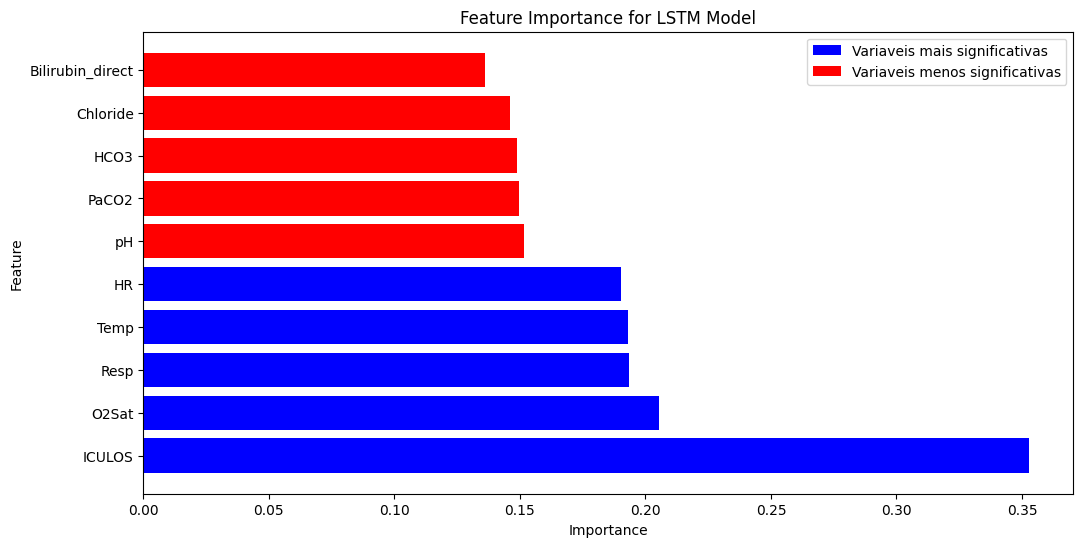

In [ ]:
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df_sorted['Feature'][:5], feature_importance_df_sorted['Importance'][:5], color='blue', label='Variaveis mais significativas')
plt.barh(feature_importance_df_sorted['Feature'][-5:], feature_importance_df_sorted['Importance'][-5:], color='red', label='Variaveis menos significativas')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for LSTM Model')
plt.legend()
plt.show()